<a href="https://colab.research.google.com/github/RayNCode/code_collab/blob/main/Main_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
X = pd.read_csv('/content/X_Data.csv', low_memory=False)
df = pd.read_csv('/content/target_data.csv')
y = df['target'].copy()
y = np.where(y == 'B', 1, 0)
X['REG'] = X['REG'].astype('object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION","work_description", "N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')

In [ ]:
def tune_hyperparameters(pipeline, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """

    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)

    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_


In [ ]:
# Define the hyperparameter grid to search
xgb_param_grid_optimized = {
    'xgbclassifier__max_depth': [4, 6],
    'xgbclassifier__learning_rate': [0.05, 0.1],
    'xgbclassifier__n_estimators': [100, 150],
    'xgbclassifier__gamma': [0, 0.1],
    'xgbclassifier__subsample': [0.8, 1],
    'xgbclassifier__colsample_bytree': [0.5, 0.7]
}

In [ ]:
XGBoost = XGBClassifier(random_state=42)
XGB = make_pipeline(preprocessing, XGBoost)

In [ ]:
xgb_opt = tune_hyperparameters(XGB, xgb_param_grid_optimized, X_train, y_train)

Best hyperparameters:
 {'xgbclassifier__colsample_bytree': 0.7, 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__subsample': 0.8}


In [45]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1], average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score','Macro AUC'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [51]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    # Set font scale
    sns.set(font_scale=1.5)

    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    # Plot confusion matrix for test set
    cmap = plt.cm.Purples  # Remplace 'purple_cmap' par 'cmap'

    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=cmap, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 3.6)
    table.set_fontsize(12)
    ax2.axis('tight')
    # Hide the axes
    ax2.axis('off')
    # set the title
    ax2.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('purple')

    plt.tight_layout()
    plt.show()


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     15412
           1       0.91      0.93      0.92     24582

    accuracy                           0.90     39994
   macro avg       0.90      0.89      0.90     39994
weighted avg       0.90      0.90      0.90     39994


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3853
           1       0.90      0.92      0.91      6146

    accuracy                           0.89      9999
   macro avg       0.88      0.88      0.88      9999
weighted avg       0.89      0.89      0.89      9999





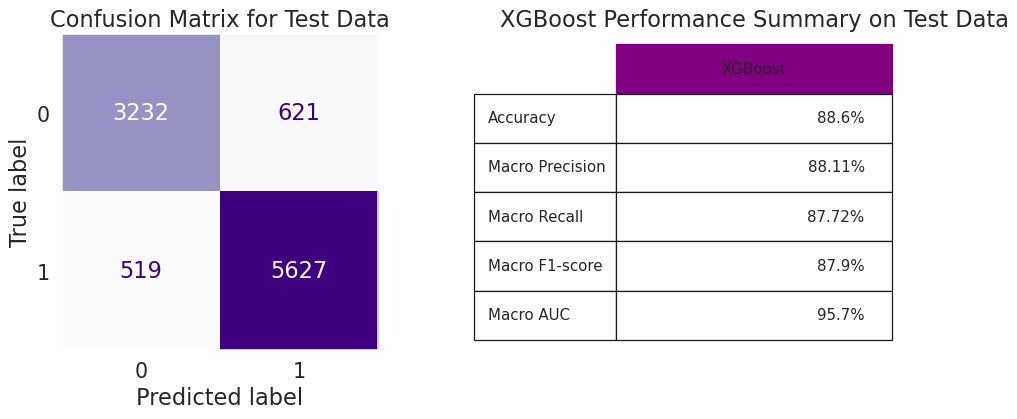

In [52]:
model_evaluation(xgb_opt, X_train, X_test, y_train, y_test, 'XGBoost')